## scVelo Basics

元URL: https://scvelo.readthedocs.io/VelocityBasics.html

最終更新日: 2023/10/1

Scanpyと同じグループが作ったRNA速度解析ツールであるscVeloのチュートリアルです。

### 前準備

Google Colabで本チュートリアルを実行する場合は、まず下記コマンドでscVeloをインストールしてください。

#### loomファイルの作成 (Optional)

自分自身のデータに対してscVeloを適用するには、まず[Velocyto](https://singlecellanalysistutorial.readthedocs.io/en/latest/notebooks/Velocyto.html)を使って.loomファイルを作成する必要があります。

（このチュートリアルではこの手続きは必要ありません。）

### scVeloのロード

In [4]:
import scvelo as scv
scv.logging.print_version()

scv.settings.verbosity = 3          # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')     # for beautified visualization

Running scvelo 0.2.5 (python 3.8.16) on 2023-10-01 17:08.


ERROR: XMLRPC request failed [code: -32500]
RuntimeError: PyPI no longer supports 'pip search' (or XML-RPC search). Please use https://pypi.org/search (via a browser) instead. See https://warehouse.pypa.io/api-reference/xml-rpc.html#deprecated-methods for more information.


### データのロード


このチュートリアルでは、テストデータとして用意されている、α、β、δ、ε細胞という4つの主要な運命への系統コミットメントを持つ [pancreas data](https://scvelo.readthedocs.io/scvelo.datasets.pancreas.html)の内分泌発生を使います。

adataオブジェクトにデータを読み込みます。adataオブジェクトはデータ行列`adata.X`、細胞アノテーション`adata.obs`、遺伝子アノテーション`adata.var`、構造化されていないアノテーション`adata.uns`を保持します。

In [5]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

これを見ると、このpancreasデータは3696細胞、27998遺伝子から成ることがわかります。
高変動遺伝子（HVG）の抽出、次元削減（PCAとUMAP）、細胞のクラスタリング、クラスタの細胞種アノテーションまで完了しています。

細胞名、遺伝子名は `adata.obs_names` and `adata.var_names` で表示できます。
AnnData objects (adata) は`adata_subset = adata[:, list_of_gene_names]`でスライス可能です。

In [6]:
adata.obs_names

Index(['AAACCTGAGAGGGATA', 'AAACCTGAGCCTTGAT', 'AAACCTGAGGCAATTA',
       'AAACCTGCATCATCCC', 'AAACCTGGTAAGTGGC', 'AAACCTGGTATTAGCC',
       'AAACCTGTCCCTCTTT', 'AAACCTGTCTTTCCTC', 'AAACGGGAGACAATAC',
       'AAACGGGAGATATGGT',
       ...
       'TTTGGTTCACCAGATT', 'TTTGGTTCACGAAGCA', 'TTTGGTTTCACTTACT',
       'TTTGGTTTCCTTTCGG', 'TTTGTCAAGAATGTGT', 'TTTGTCAAGTGACATA',
       'TTTGTCAAGTGTGGCA', 'TTTGTCAGTTGTTTGG', 'TTTGTCATCGAATGCT',
       'TTTGTCATCTGTTTGT'],
      dtype='object', name='index', length=3696)

In [7]:
adata.var_names

Index(['Xkr4', 'Gm37381', 'Rp1', 'Rp1-1', 'Sox17', 'Gm37323', 'Mrpl15',
       'Rgs20', 'Npbwr1', '4732440D04Rik',
       ...
       'Gm28406', 'Gm29436', 'Gm28407', 'Gm29393', 'Gm21294', 'Gm28672',
       'Gm28670', 'Gm29504', 'Gm20837', 'Erdr1'],
      dtype='object', name='index', length=27998)

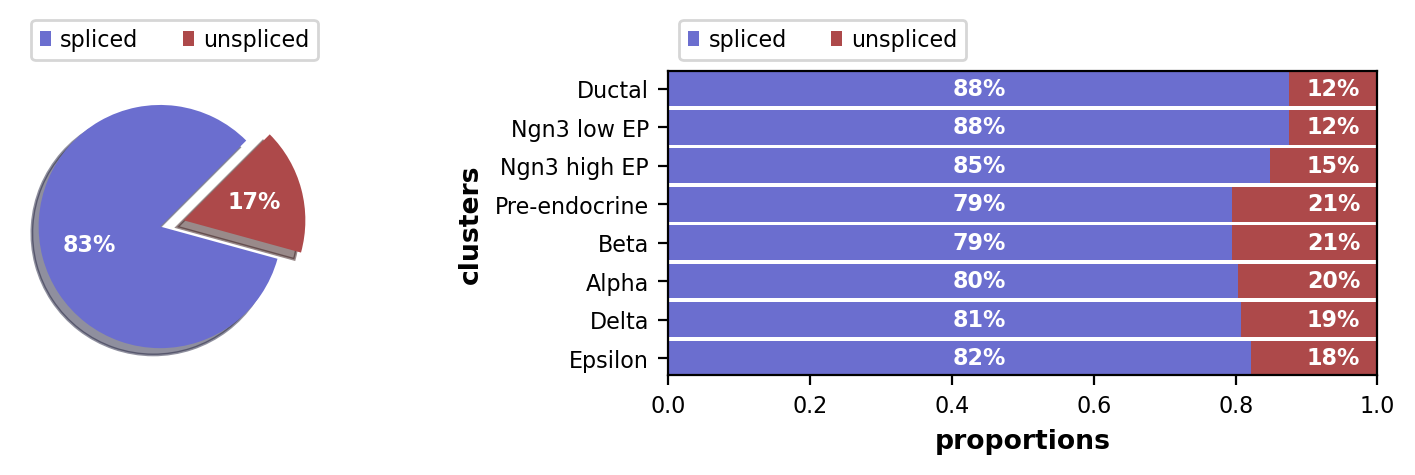

In [8]:
scv.pl.proportions(adata)

- `scv.pl.proportions`関数を使うと、spliced/unspliced mRNA数の割合が表示されます。使用したプロトコル（Drop-Seq、Smart-Seq）にもよりますが、通常、intron配列を含むスプライスされていない分子が10％～25％程度存在します。
- スプライシング効率の一貫性を確認するために、クラスターレベルでのばらつきを調べることをお勧めします。ここでは予想通りのばらつきが見られ、周期性管細胞 (cycling ductal cells)ではスプライスされていない分子の割合がわずかに低く、その後、多くの遺伝子が転写され始めるNgn3-high細胞やPre-endocrine細胞では、細胞運命コミットメントでの割合が高くなっていることがわかりました。

### データの前処理

- 前処理にはHVGの抽出と、発現量の正規化・対数化が含まれます。

- フィルタリングと正規化は、遺伝子発現量およびspliced/unspliced カウントに同じように適用されます。

- これらはすべて単一の関数 ``scv.pp.filter_and_normalize`` にまとめられており、以下の４つのコマンドが含まれます。

In [9]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)

# ↑のコマンドは以下の４つを実行したのと同じ
#scv.pp.filter_genes(adata, min_shared_counts=20)
#scv.pp.normalize_per_cell(adata)
#scv.pp.filter_genes_dispersion(adata, n_top_genes=2000)
#scv.pp.log1p(adata)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


- さらに、PCA空間上のnearest neighborsで計算された1次と2次のモーメント (means and uncentered variances)  が必要です。
- 決定論的なRNA速度推定 (deterministic velocity estimation) では1次モーメントのみ必要ですが、デフォルトである確率的速度推定 (stochastic estimation) には2次モーメントが必要となります。
- これには`scv.pp.moments`関数を用います。この関数は内部で`scv.pp.pca`と`scv.pp.neighbors`を実行しています。

In [10]:
# 第30主成分までを使い、30-NNで計算
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


### さらなる前処理 (optional)
- 不要な変動源を除去するため、バッチ効果補正などのさらなる前処理を使用してもよい。
- バッチ補正の詳細は [best practiceの論文](https://www.embopress.org/doi/full/10.15252/msb.20188746) を参照。
- 追加の前処理ステップは遺伝子発現量 (`adata.X`) にのみ影響し、spliced/unspliced mRNA数には適用されないことに注意。

### RNA速度 (velocity) の推定


- Velocityは遺伝子発現空間におけるベクトルであり、個々の細胞の移動の「方向」と「速度」を表します。
    - Velocity = speed + direction
- このVelocityは、スプライシング動態の転写ダイナミクスを確率的（stochastic, デフォルト）または決定論的 (`mode='deterministic'` オプションで指定)にモデル化することで得られます。
- 各遺伝子について、pre-mature (unspliced)とmature (spliced)の mRNA数の定常状態比 (steady-state-ratio) がフィットされます。Velocityはこの比率の残差として得られる。
- 正のVelocityは、ある遺伝子が発現上昇していることを示しており、定常状態で予想されるよりも多くunspliced mRNAが存在する細胞で発生します。逆に、負の速度は遺伝子がダウンレギュレーションされていることを示しています。

- 完全な動的モデルの解は、`mode='dynamical'`を設定することで得られます。このモードは事前に `scv.tl.recover_dynamics(adata)` を実行しておく必要があります。このモデルについては次のチュートリアルで詳しく説明します。

In [11]:
scv.tl.velocity(adata)

computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


計算されたvelocityは、count行列と同様に `adata.layer` に保存されます。


- 遺伝子間のvelocityの組み合わせは、各細胞の将来の状態を推定するのに使われる。
- Velocityを低次元の埋め込み (embedding) に投影するために、細胞間の遷移確率を推定する。つまり、各velocityベクトルについて、その方向に沿った細胞遷移の可能性が高いものを見つけます。
- 遷移確率は細胞間遷移の可能性とvelocityベクトルとの間のコサイン相関を用いて計算され、velocity graphと呼ばれる行列として格納されます。
- 得られるvelocity graphは$n_{obs} \times n_{obs}$ の次元を持ち、速度ベクトルによって説明できる細胞の状態変化を要約しています。
   - 高速化のために、`approx=True`を設定することで、縮小されたPCA空間上で計算することもできます。

In [13]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/40 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


- 様々な応用のために、ガウスカーネルを適用してコサイン類似度を実際の遷移確率に変換することで、velocity graphを遷移行列に変換することができます。
- マルコフ遷移行列には `scv.utils.get_transition_matrix` でアクセスできます。

- 前述したように、velocity graphは内部的に、`scv.tl.velocity_embedding`関数で得られた遷移確率に対する平均遷移を計算することで、低次元の埋め込みに速度を投影するために使用されます。
- さらに、マルコフ連鎖に沿って細胞をその始点と潜在的な運命までトレースすることができ、それにより、軌道のルートと終点を得ることができます。これは `scv.tl.terminal_states` で参照できます。

### RNA速度の投影

- 最終的に、velocityは任意の低次元埋め込みに投影され、以下のいずれかの方法で可視化されます。
    - 細胞レベル： `scv.pl.velocity_embedding`,
    - グリッドライン： `scv.pl.velocity_embedding_grid`,
    - ストリームライン： `scv.pl.velocity_embedding_stream`.

- デモデータには既に計算済みの UMAPデータと注釈付きクラスタが含まれています。
- 自分のデータに適用する場合、これらは `scv.tl.umap` と `scv.tl.louvain` で取得できます。詳細については、[scanpyのチュートリアル](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)を参照してください。
- すべてのプロット関数はデフォルトで`basis='umap'`と`color='cluster'`を使用します。

### ストリームラインvelocity 

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


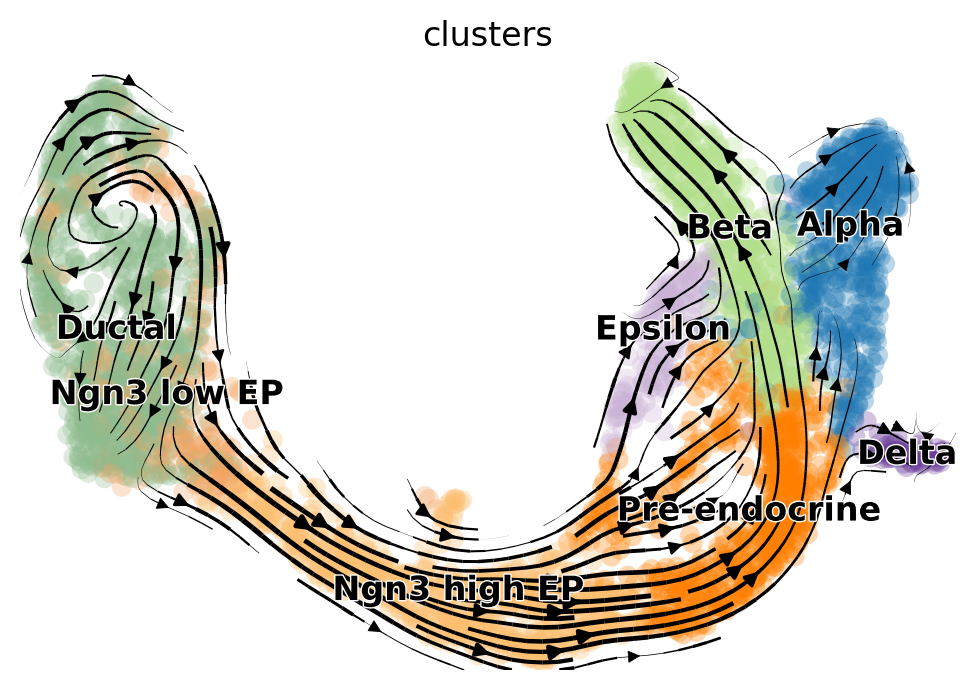

In [14]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

- ストリームラインとして表示されるvelocity ベクトル場は、発生過程に対する詳細な洞察をもたらす。
     - 管腔細胞 (ductal cells) と内分泌前駆細胞 (endocrine progenitors) の循環集団を正確に描き出します。
     - さらに、細胞の系統コミットメント、細胞周期の出口、および内分泌細胞の分化などの細胞の状態を明らかにする。

### 細胞レベル velocity 

- 速度ベクトル場は1細胞レベルでも得られます。各矢印は各細胞の移動方向と速度を示しています。
- これにより、例えばNgn3細胞（黄色）の早期の内分泌関与や、末期に近いα細胞（青）と一過性のβ細胞（緑）の間の明確な違いが明らかになります。

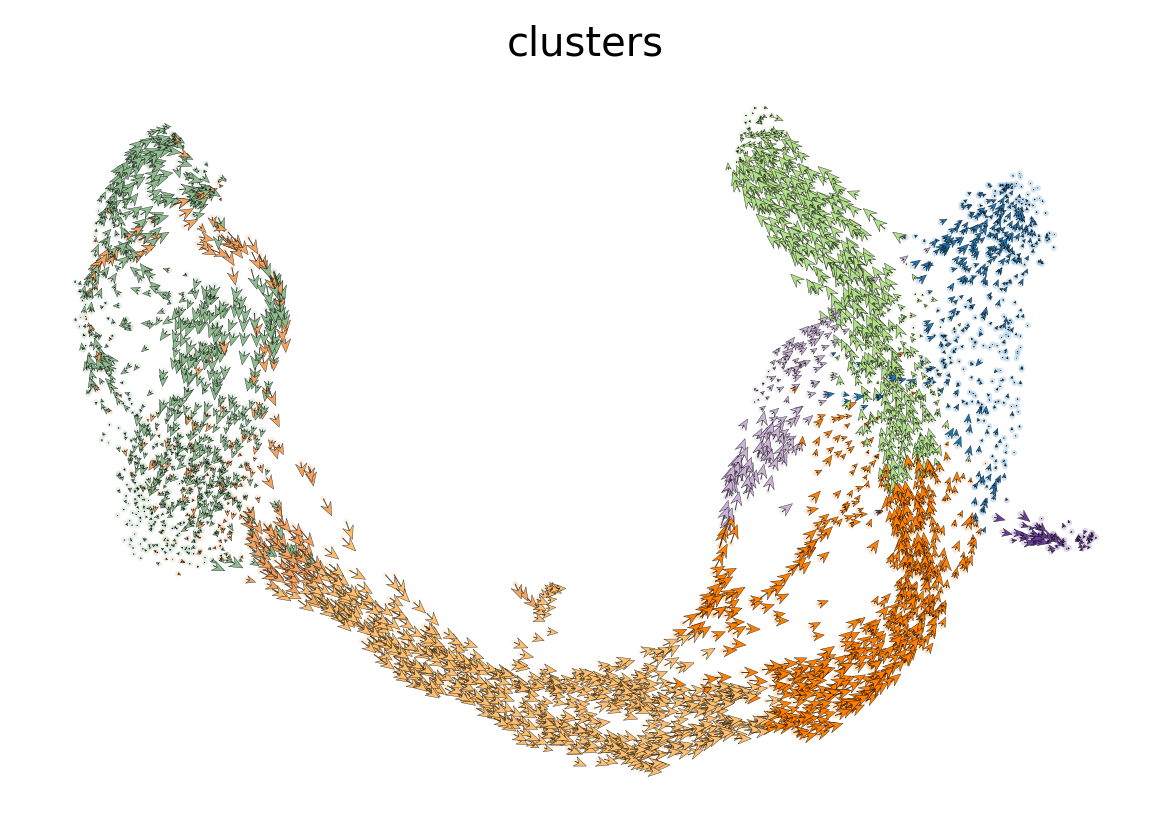

In [15]:
scv.pl.velocity_embedding(adata, arrow_length=3, arrow_size=2, dpi=120)

### RNA速度の解釈

これはおそらく最も重要な部分です。つまり、生物学的な結論を投影された速度に限定するのではなく、推定された方向性が特定の遺伝子によってどのように支持されているかを理解するために、位相ポートレート (phase portraits)を通して個々の遺伝子のダイナミクスを調べるべきです。

スプライスされた位相ポートレイトとスプライスされていない位相ポートレイトをどのように解釈するかについては、[こちらのgif](https://user-images.githubusercontent.com/31883718/80227452-eb822480-864d-11ea-9399-56886c5e2785.gif) を参照してください。
   - 遺伝子の活性は転写制御によって調整されている。
   - 特定の遺伝子に対して転写が誘導されると、（新たに転写された）precursor unspliced mRNAsが増加し、逆に転写が抑制されたり、転写が行われなかったりすると、unspliced mRNAsが減少します。
   - スプライスされたmRNAは、unspliced mRNAから産生され、時間差を伴って同じ傾向をたどる。
   - 時間は隠れた/潜在的な変数である。従って、ダイナミクスは実際に測定されたものから推測する必要がある。すなわち位相ポートレートに表示されているspliced and unspliced mRNAsからダイナミクスを推測する必要があります。

それでは、 `scv.pl.velocity(adata, gene_names)` または `scv.pl.scatter(adata, gene_names)` で可視化したマーカー遺伝子の位相ポートレートを見てみましょう。

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecate

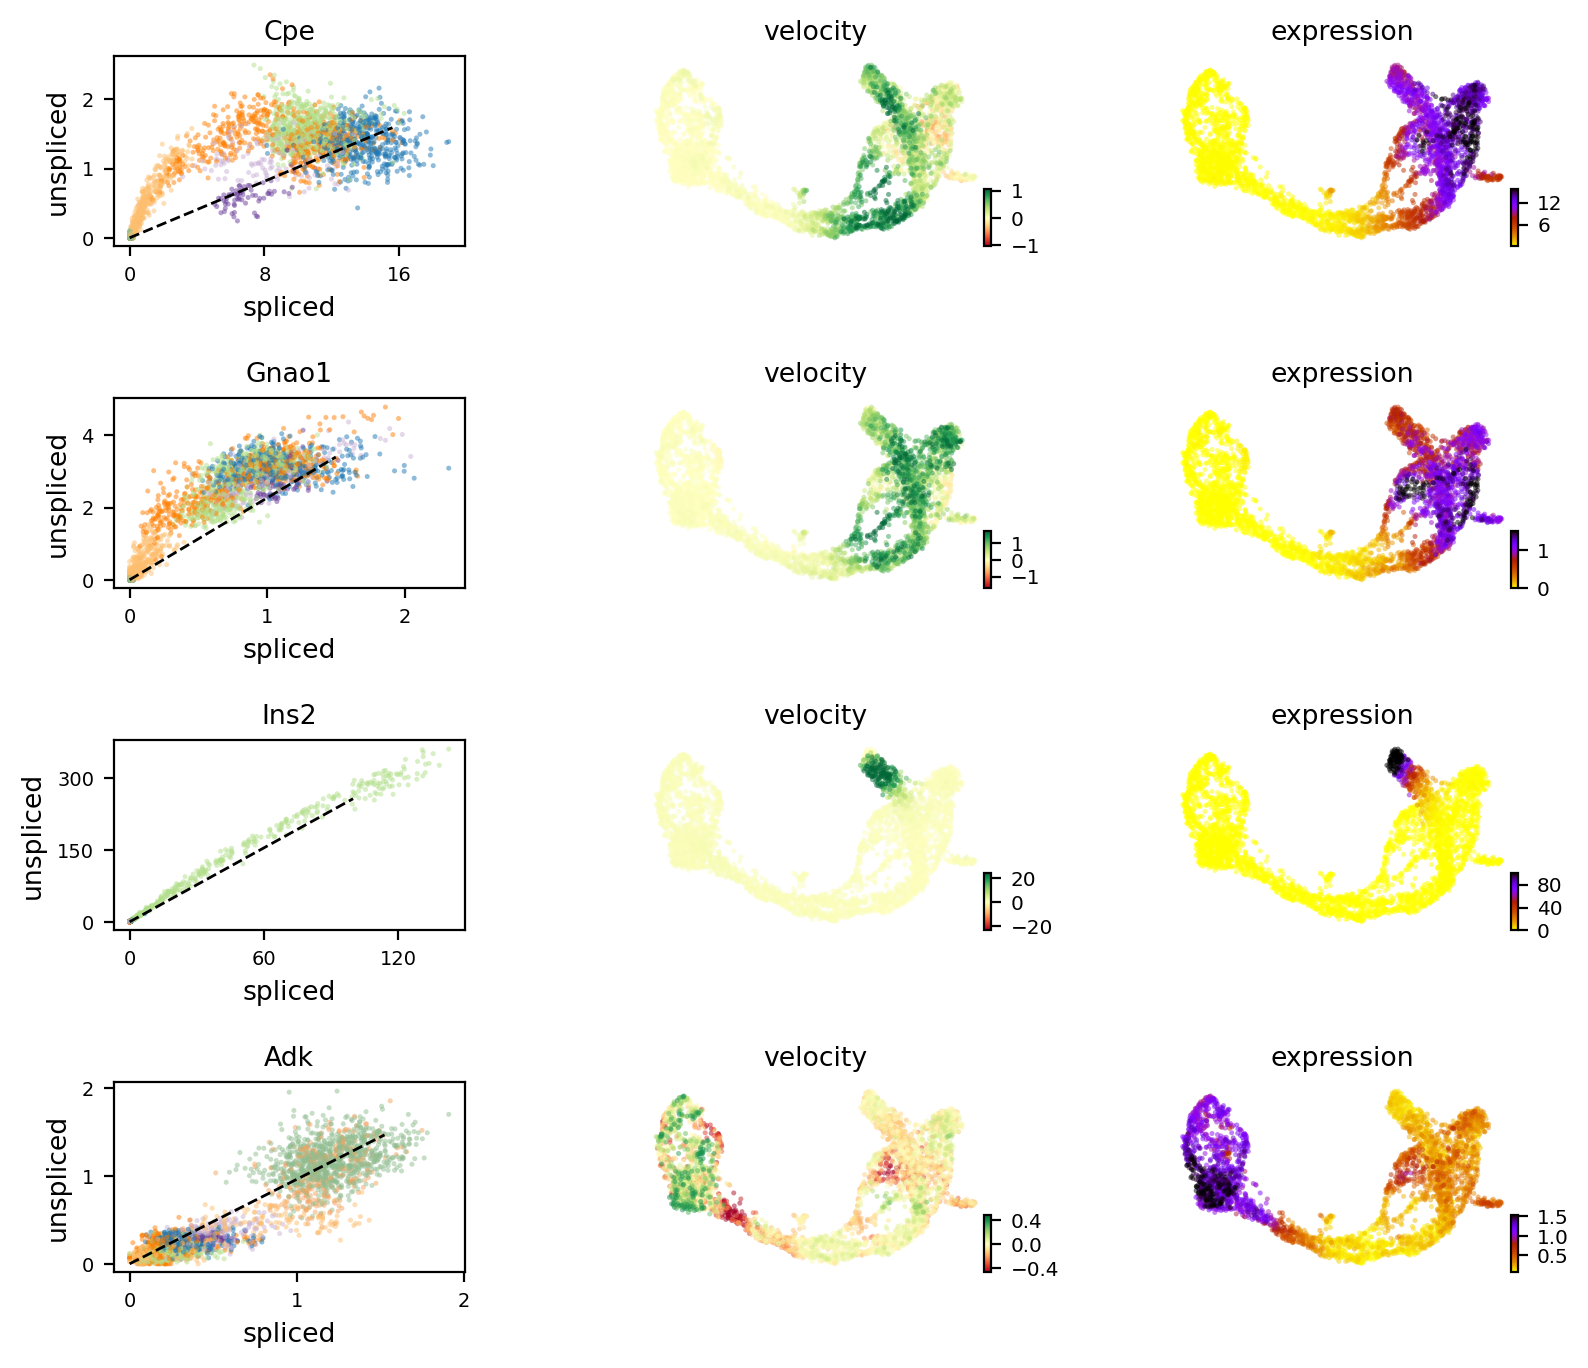

In [17]:
scv.pl.velocity(adata, ['Cpe',  'Gnao1', 'Ins2', 'Adk'], ncols=1)

- 黒線は推定された定常状態の比率、すなわち一定の転写状態における スプライスされていないmRNA量とスプライスされたmRNA量の比率に対応する。
- 特定の遺伝子のRNA速度は残差として決定される。すなわち、観測がその定常状態線 (黒線)からどれだけずれているかということである。
- 正の速度は、ある遺伝子が発現上昇していることを示しており、定常状態で予想されるよりもunspliced mRNAが豊富な細胞で発生します。逆に、負の速度は遺伝子が発現抑制されていることを示しています。

- 例えば、Cpeは発現上昇したNgn3（黄色）→ Pre-endocrine（オレンジ）→ β細胞（緑）への方向性を説明し、Adkは発現抑制されたDuctal（濃い緑）→ Ngn3（黄色）→ 残りの内分泌細胞への方向性を説明しています。


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


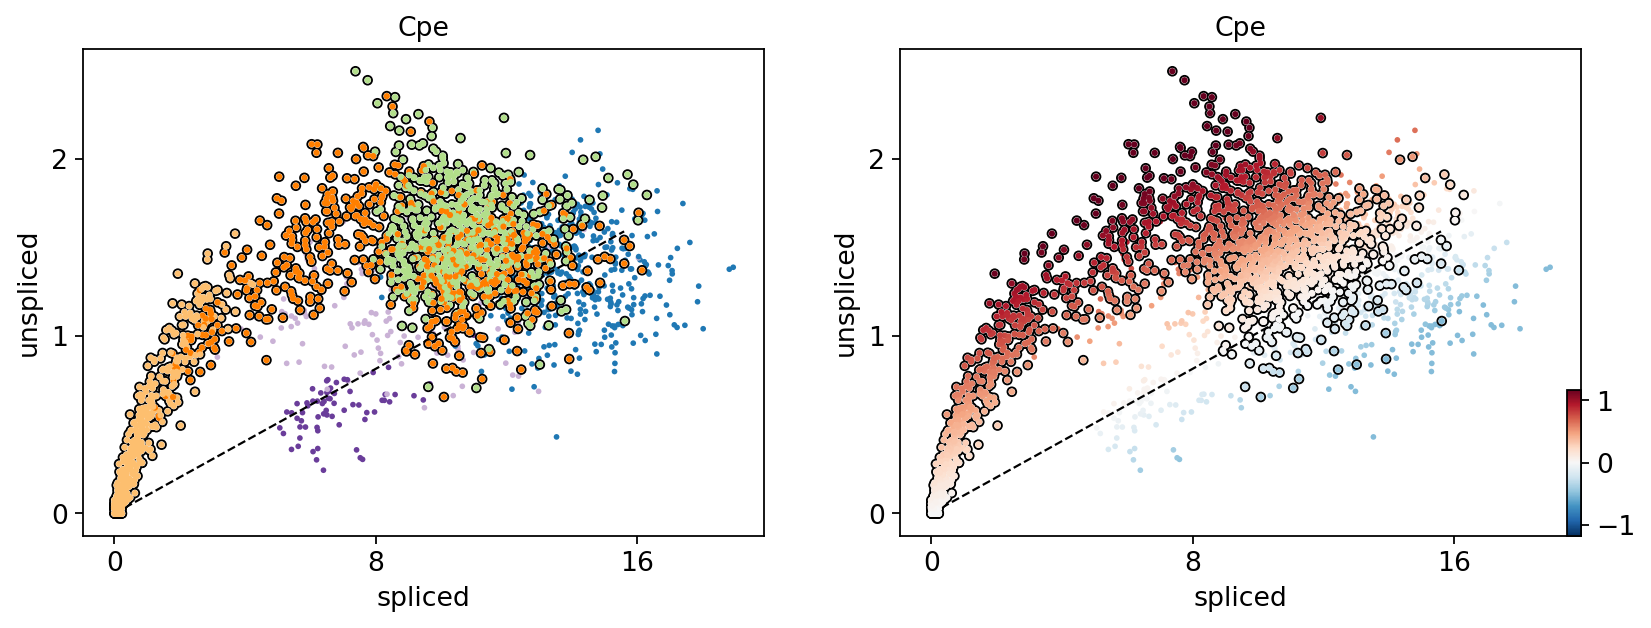

In [18]:
scv.pl.scatter(adata, 'Cpe', color=['clusters', 'velocity'],
               add_outline='Ngn3 high EP, Pre-endocrine, Beta')

### 重要な遺伝子の同定

- 得られるベクトル場と推定される系統を説明するのに役立つ遺伝子を特定する体系的な方法が必要である。
- そのために、どの遺伝子がクラスター特異的な速度差発現を持ち、残りの集団と比較して有意に高いか低いかを検定します。

- `scv.tl.rank_velocity_genes` モジュールは 差分速度のt-test を実行し、各クラスタの遺伝子ランキングを出力します。
- 遺伝子候補選択を制限するための閾値を設定することができます (例: `min_corr`)。

In [19]:
scv.tl.rank_velocity_genes(adata, groupby='clusters', min_corr=.3)

df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])
df.head()

ranking velocity genes


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/tools/utils.py:501: DeprecationWarning: Please use `rankdata` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import rankdata


    finished (0:00:02) --> added 
    'rank_velocity_genes', sorted scores by group ids (adata.uns) 
    'spearmans_score', spearmans correlation scores (adata.var)


/tmp/ipykernel_170222/1614465797.py:3: DeprecationWarning: `scvelo.read_load.get_df` is deprecated since scVelo v0.2.4 and will be removed in a future version. Please use `scvelo.core.get_df` instead.
  df = scv.DataFrame(adata.uns['rank_velocity_genes']['names'])


Ductal Ngn3 low EP Ngn3 high EP Pre-endocrine     Beta    Alpha    Delta  \
0  Notch2       Ptpn3        Pde1c           Pam     Pax6  Zcchc16    Zdbf2   
1    Sox5       Hacd1        Ptprs          Sdk1    Unc5c    Nlgn1   Spock3   
2   Krt19       Hspa8         Pclo        Baiap3     Nnat    Nell1  Akr1c19   
3   Hspa8      Gm8113     Rap1gap2         Abcc8  Tmem108   Prune2    Ptprt   
4    Ano6       Kcnq1        Ttyh2          Gnas    Ptprt     Ksr2   Snap25   

  Epsilon  
0   Tmcc3  
1    Heg1  
2  Gpr179  
3    Ica1  
4   Ncoa7

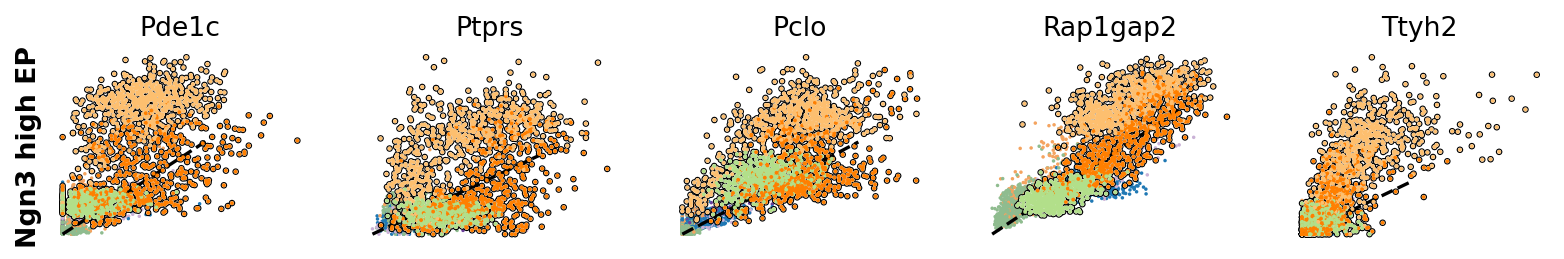

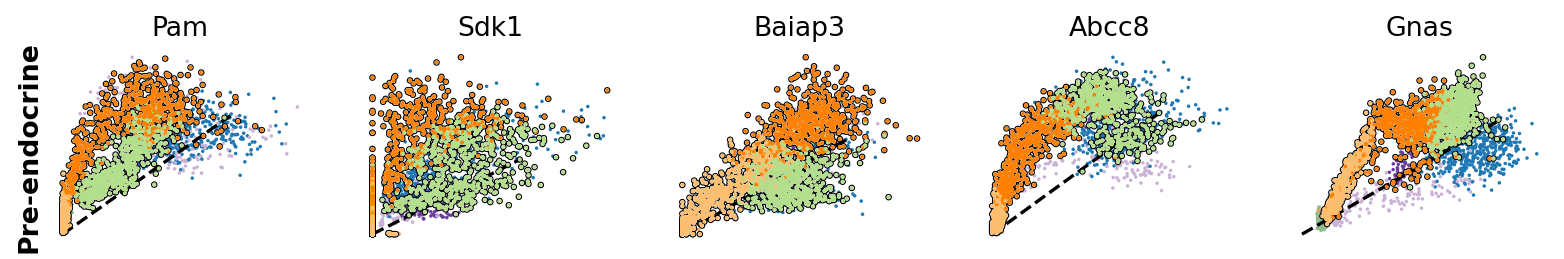

In [20]:
kwargs = dict(frameon=False, size=10, linewidth=1.5,
              add_outline='Ngn3 high EP, Pre-endocrine, Beta')

scv.pl.scatter(adata, df['Ngn3 high EP'][:5], ylabel='Ngn3 high EP', **kwargs)
scv.pl.scatter(adata, df['Pre-endocrine'][:5], ylabel='Pre-endocrine', **kwargs)

例えば、Ptprs、Pclo、Pam、Abcc8、Gnasなどの遺伝子は、Ngn3 high EP（黄色）→Pre-endocrine（オレンジ）→Beta（緑）という方向性を示しています。

### 循環する前駆細胞のRNA速度
RNA速度によって検出される細胞周期は、細胞周期スコア（位相マーカー遺伝子の平均発現量を標準化したスコア）によって生物学的に確認されます。

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


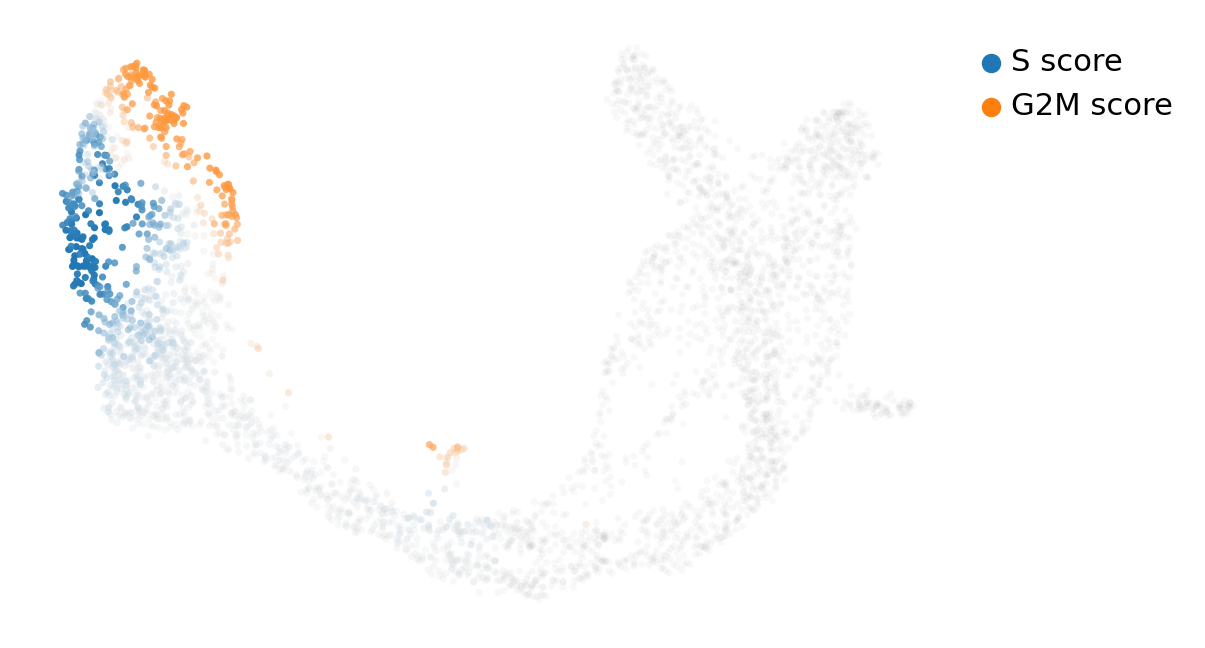

In [21]:
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

周期性のある管状細胞 (Ductal cells)については、SとG2Mのマーカーでスクリーニングすることができます。上のモジュールはまた、スピアマン相関係数を計算してマーカー遺伝子をランク付けやソートし、それらの位相ポートレートを表示することができます。

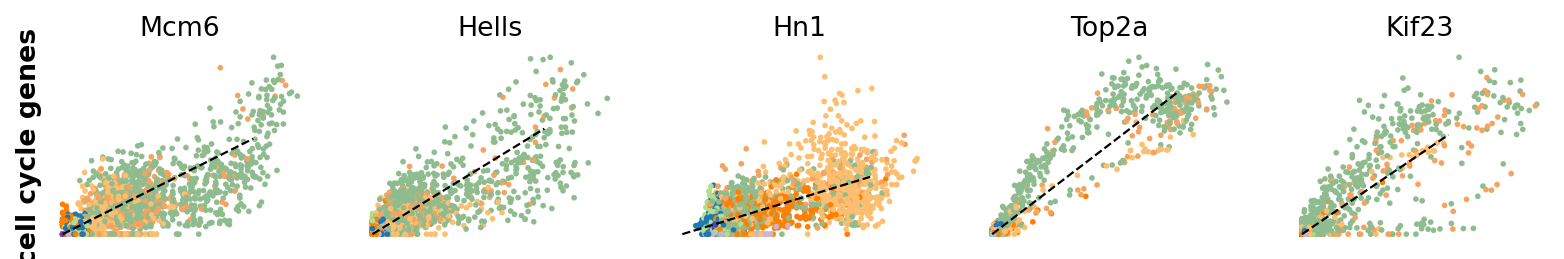

In [22]:
s_genes, g2m_genes = scv.utils.get_phase_marker_genes(adata)
s_genes = scv.get_df(adata[:, s_genes], 'spearmans_score', sort_values=True).index
g2m_genes = scv.get_df(adata[:, g2m_genes], 'spearmans_score', sort_values=True).index

kwargs = dict(frameon=False, ylabel='cell cycle genes')
scv.pl.scatter(adata, list(s_genes[:2]) + list(g2m_genes[:3]), **kwargs)

特にHellsとTop2aは、循環する前駆体のベクトル場を説明するのに適しています。
Top2aはG2M期でピークに達する直前に高い速度を示す。そこでは負の速度が直後の発現低下に完全に一致する。

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()
/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


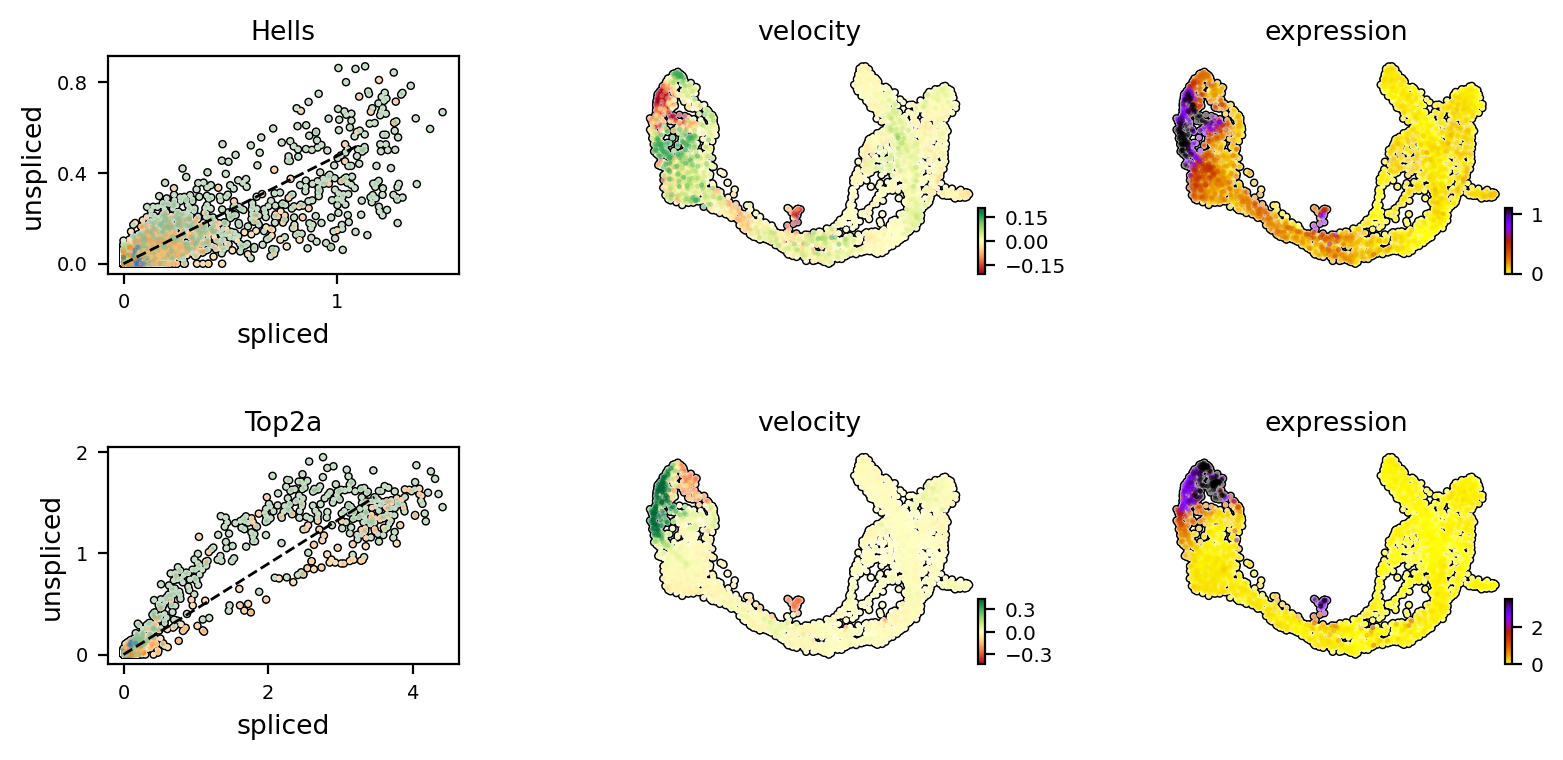

In [25]:
scv.pl.velocity(adata, ['Hells', 'Top2a'], ncols=1, add_outline=True)

### 速度とコヒーレンス

さらに2つの有用な統計量があります。
   - 速度または微分の速度は速度ベクトルの長さで与えられます。
   - ベクトル場のコヒーレンス（すなわち、速度ベクトルが隣接する速度とどのように相関するか）は、信頼性の尺度となります。

--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


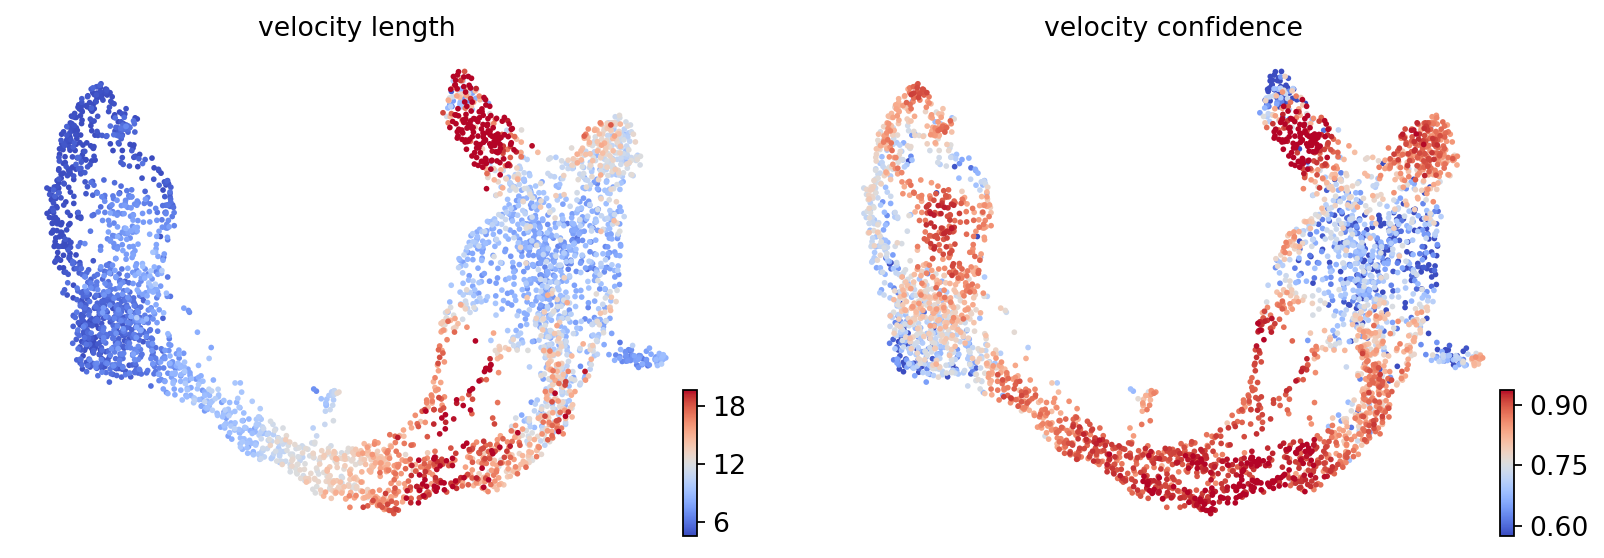

In [26]:
scv.tl.velocity_confidence(adata)
keys = 'velocity_length', 'velocity_confidence'
scv.pl.scatter(adata, c=keys, cmap='coolwarm', perc=[5, 95])

これらの結果から、細胞がどのようなペースで分化するのか、またその方向性はどのようなものなのかが明らかになった。

クラスターレベルでは、細胞周期の終了後（Ngn3低EP）には分化が大幅に加速し、ベータ細胞産生時にはペースを維持し、アルファ細胞産生時にはペースが低下することがわかります。

In [27]:
df = adata.obs.groupby('clusters')[keys].mean().T
df.style.background_gradient(cmap='coolwarm', axis=1)

### Velocity graphと擬似時間

- Velocityグラフを可視化することで、推定された全ての細胞間接続/遷移を描写することができます。
- 閾値を設定することで、高確率の遷移に限定することもできる。
- 例えば、このグラフは初期と後期の前内分泌細胞からのイプシロン細胞生産の2つのフェーズを示しています。

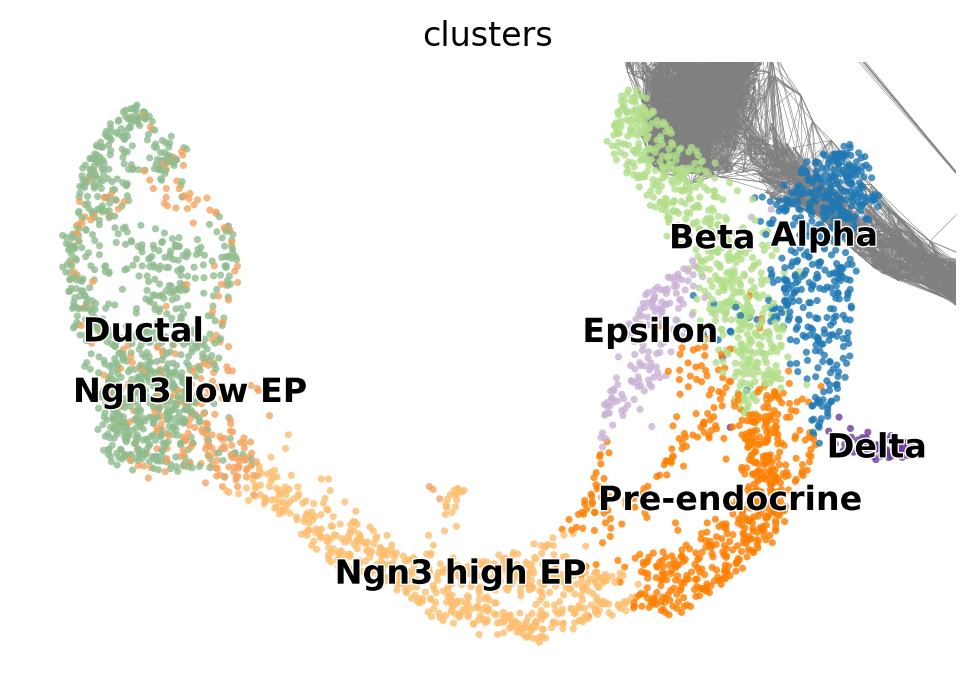

In [28]:
scv.pl.velocity_graph(adata, threshold=.1)

さらに、このグラフを使って、指定した細胞の子孫/先祖を描くことができる。ここでは、内分泌前細胞をその潜在的な運命までたどっている。

/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


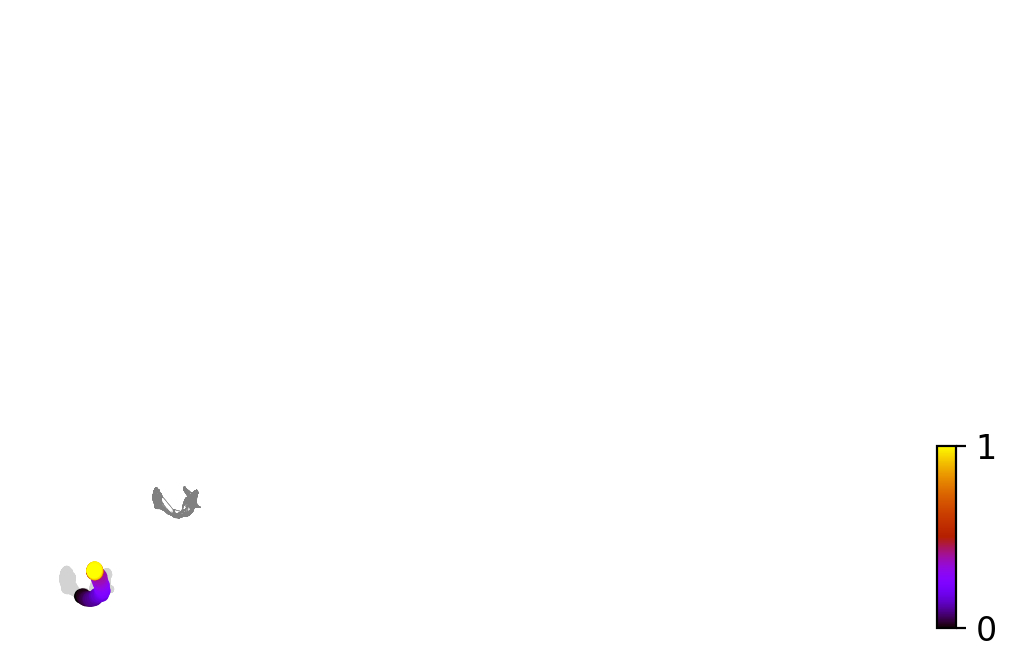

In [29]:
x, y = scv.utils.get_cell_transitions(adata, basis='umap', starting_cell=70)
ax = scv.pl.velocity_graph(adata, c='lightgrey', edge_width=.05, show=False)
ax = scv.pl.scatter(adata, x=x, y=y, s=120, c='ascending', cmap='gnuplot', ax=ax)

（訳者注：ここだけバグなのか、Tutorialと異なる図が示されてしまっています。本当はどういう図になるのかは元URLで確認してください。）

- 最後に、速度グラフに基づいて、 velocity擬似時間を計算することができる。
- グラフからroot細胞からの分布を推定した後、root細胞からグラフに沿って歩き、その細胞に到達するまでにかかる平均ステップ数を測定することで計算されます。

- diffusion pseudotimeとは逆に、root細胞を暗黙的に推定し、類似度ベースの拡散カーネルの代わりに有向速度グラフに基づいています。


computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


/opt/conda/envs/shortcake_default/lib/python3.8/site-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


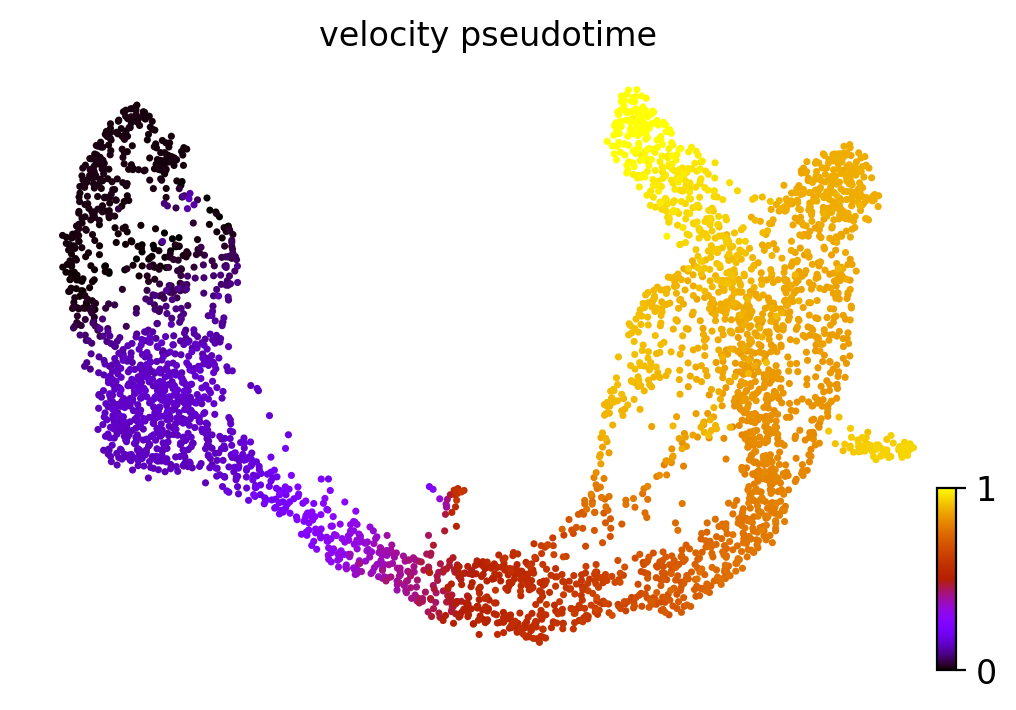

In [30]:
scv.tl.velocity_pseudotime(adata)
scv.pl.scatter(adata, color='velocity_pseudotime', cmap='gnuplot')

### PAGA velocity graph

- [PAGA](https://github.com/theislab/paga)によるグラフの粗視化は、軌跡推論のための最高性能の手法としてベンチマークされています。
- PAGAは、2つのクラスタ間の接続性に対応した重み付きエッジを用いて、データトポロジーのグラフ状のマップを提供する。
- ここでは、PAGAをRNA速度の方向性に基づいて拡張しています。

In [32]:
# this is needed due to a current bug - bugfix is coming soon.
adata.uns['neighbors']['distances'] = adata.obsp['distances']
adata.uns['neighbors']['connectivities'] = adata.obsp['connectivities']

scv.tl.paga(adata, groups='clusters')
df = scv.get_df(adata, 'paga/transitions_confidence', precision=2).T
df.style.background_gradient(cmap='Blues').format('{:.2g}')

running PAGA using priors: ['velocity_pseudotime']
    finished (0:00:00) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
    'paga/transitions_confidence', velocity transitions (adata.uns)


これは、左/行から右/列へと読み取ることができ、例えば、DuctalからNgn3 low EPへの信頼性ある遷移を割り当てることができる。

この表は、UMAP上に埋め込まれた有向グラフで要約できる。

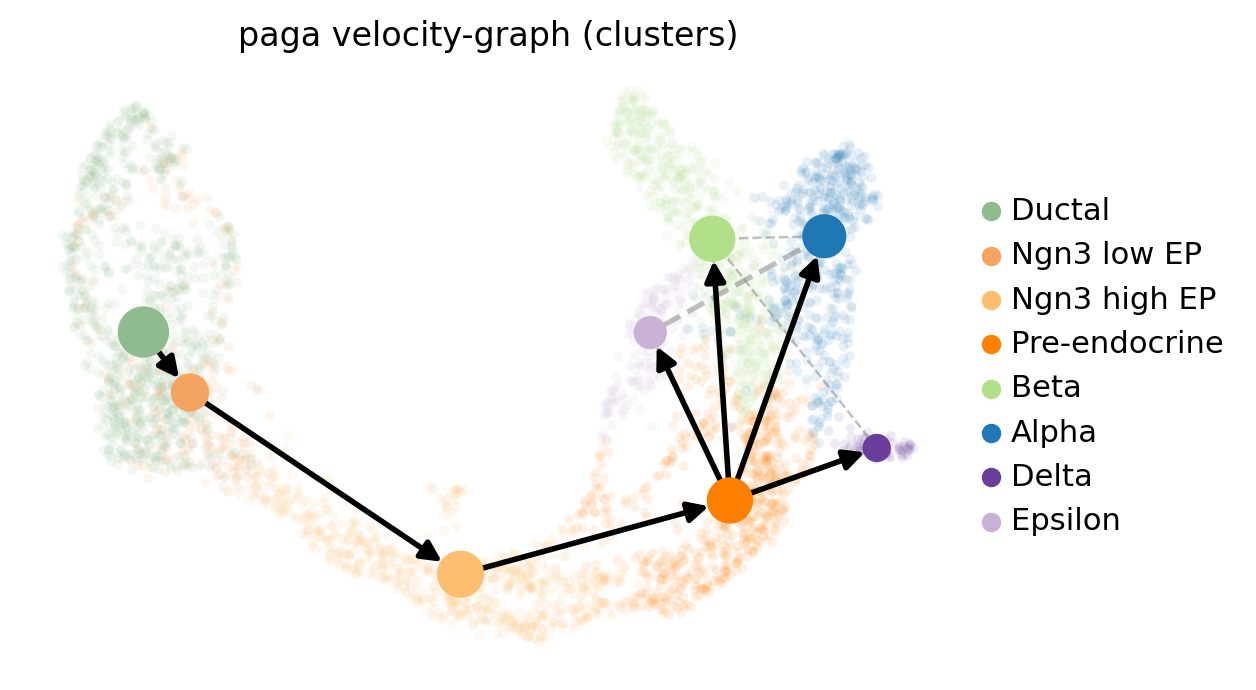

In [33]:
scv.pl.paga(adata, basis='umap',
            size=50,
            alpha=.1,
            min_edge_width=2,
            node_size_scale=1.5)

In [34]:
import session_info
session_info.show()